# Import Libraries and Preprocess Data

In [ ]:
!pip install -q -r '/content/drive/MyDrive/Realtime Tracking/requirements.txt'

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os, sys, cv2, torch, datetime, torchreid
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLOv10

In [ ]:
video_path = "/content/drive/MyDrive/Realtime Tracking/Test.mp4"
if video_path.isdigit(): cap = cv2.VideoCapture(int(video_path))
else: cap = cv2.VideoCapture(video_path)

In [ ]:
classes_path = "/content/drive/MyDrive/Realtime Tracking/coco.names"
with open(classes_path, "r") as f:
    class_names = f.read().strip().split("\n")
class_names[:4]

['person', 'bicycle', 'car', 'motorbike']

In [ ]:
colors = np.random.randint(0, 255, size=(len(class_names), 3))

In [ ]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} as processing device")

Using cpu as processing device


# Initialize YOLO

In [ ]:
!mkdir -p weights
!wget -P weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt

In [ ]:
model_path = "/content/weights/yolov10n.pt"
model = YOLOv10(model_path)
model.to(device)

YOLOv10(
  (model): YOLOv10DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track

# Initialize ReID Model

In [ ]:

# Load PCB model
def initialize_pcb_model():
    model_pcb = torchreid.models.build_model(
        name='pcb_p6',
        num_classes=1041,
        loss='softmax',
        pretrained=True
    )
    model_pcb = model_pcb.to(device)
    model_pcb.eval()
    return model_pcb

# Extract features for re-identification
def extract_features(model_pcb, img):
    if img is None or img.size == 0:
        return None

    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    transform = torchreid.data.transforms.build_transforms(
        height=256,
        width=128,
        transforms=['random_flip', 'random_crop', 'random_erase']
    )[1]

    img = transform(img).unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        features = model_pcb(img)

    return features.cpu().numpy().squeeze()

pcb_model = initialize_pcb_model()

# Process Frame

In [ ]:
# Function to check if two bounding boxes overlap
def is_overlap(bbox1, bbox2, threshold=0.5):
    x1, y1, x2, y2 = bbox1
    xx1, yy1, xx2, yy2 = bbox2

    xi1 = max(x1, xx1)
    yi1 = max(y1, yy1)
    xi2 = min(x2, xx2)
    yi2 = min(y2, yy2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    bbox1_area = (x2 - x1) * (y2 - y1)
    bbox2_area = (xx2 - xx1) * (yy2 - yy1)

    union_area = bbox1_area + bbox2_area - inter_area

    return inter_area / union_area > threshold

In [ ]:
# Process frame and display
def process_frame(frame, tracker, motorbike_owners, track_class_mapping, class_counters):
    results = model(frame)[0]
    detections = []
    motorbikes = []
    persons = []

    for det in results.boxes:
        label, confidence, bbox = det.cls, det.conf, det.xyxy[0]
        x1, y1, x2, y2 = map(int, bbox)
        class_id = int(label)

        if confidence < 0.5: continue

        if class_id in [0, 1, 3]:
            detections.append([[x1, y1, x2 - x1, y2 - y1], confidence, class_id])

            if class_id == 0:
                persons.append([x1, y1, x2, y2])

            else:
                motorbikes.append([x1, y1, x2, y2])

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        class_id = track.get_det_class()
        color = colors[class_id]
        B, G, R = map(int, color)

        track_id = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())

        if track_id not in track_class_mapping:
            track_class_mapping[track_id] = len(track_class_mapping) + 1

        if class_id == 1 or class_id == 3:  # Motorbike
            if track_class_mapping[track_id] not in motorbike_owners:
                motorbike_owners[track_class_mapping[track_id]] = []

        elif class_id == 0:  # Person
            cropped_img = frame[y1:y2, x1:x2]
            new_features = extract_features(pcb_model, cropped_img)
            if new_features is None:
                continue

            matched = False
            for motorbike_bbox in motorbikes:
                if is_overlap([x1, y1, x2, y2], motorbike_bbox):
                    motorbike_id = track_class_mapping[track_id]

                    if motorbike_id in motorbike_owners:
                        features_list = motorbike_owners[motorbike_id]
                        for saved_feature in features_list:
                            similarity = cosine_similarity([new_features], [saved_feature])[0][0]
                            if similarity > 0.7:
                                motorbike_owners[motorbike_id].append(new_features)
                                matched = True
                                break
                    if not matched:
                        motorbike_owners[motorbike_id] = [new_features]
                    break

        text = f"{track_class_mapping[track_id]} - {class_id}"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (B, G, R), 2)
        cv2.rectangle(frame, (x1 - 1, y1 - 20), (x1 + len(text) * 12, y1), (B, G, R), -1)
        cv2.putText(frame, text, (x1 + 5, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    plt.pause(0.1)
    writer.write(frame)

# Real-Time Processing Loop


0: 384x640 2 3s, 621.4ms
Speed: 3.6ms preprocess, 621.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


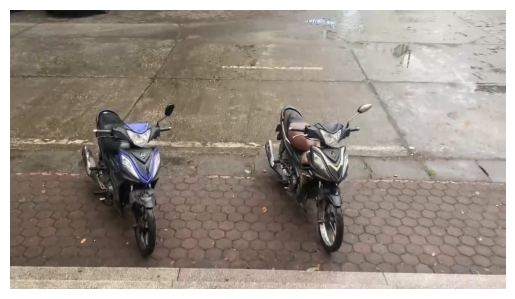


0: 384x640 2 3s, 256.7ms
Speed: 11.2ms preprocess, 256.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


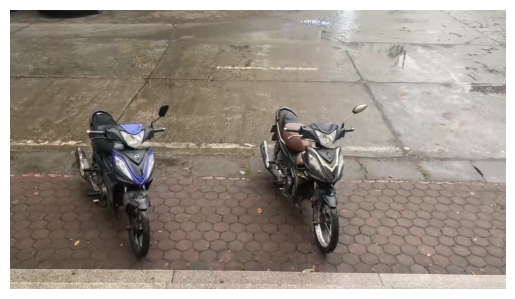


0: 384x640 2 3s, 183.0ms
Speed: 4.3ms preprocess, 183.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


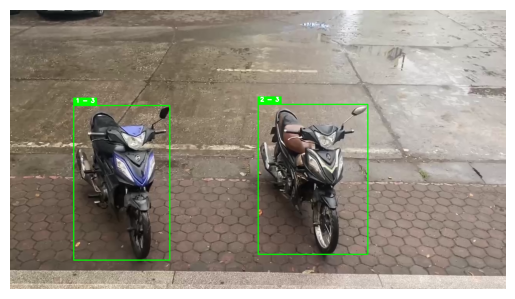


0: 384x640 2 3s, 165.1ms
Speed: 6.7ms preprocess, 165.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


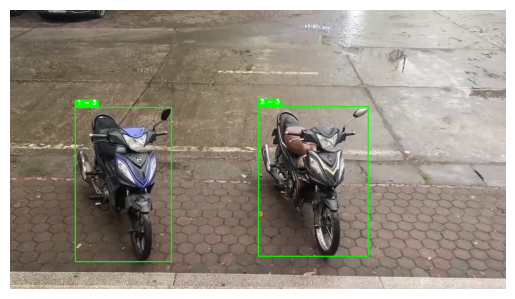


0: 384x640 2 3s, 168.4ms
Speed: 7.9ms preprocess, 168.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


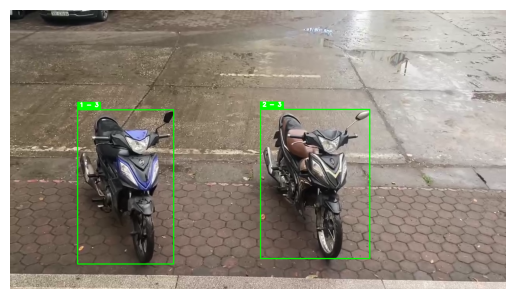


0: 384x640 2 3s, 175.9ms
Speed: 4.2ms preprocess, 175.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


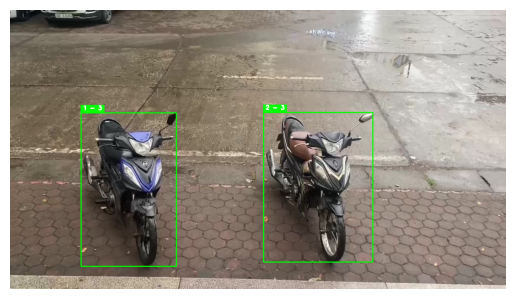


0: 384x640 1 2, 2 3s, 181.7ms
Speed: 3.5ms preprocess, 181.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


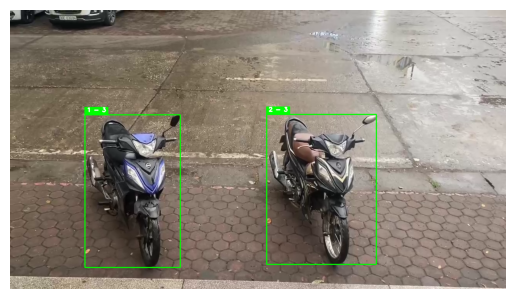


0: 384x640 1 2, 2 3s, 183.3ms
Speed: 2.7ms preprocess, 183.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


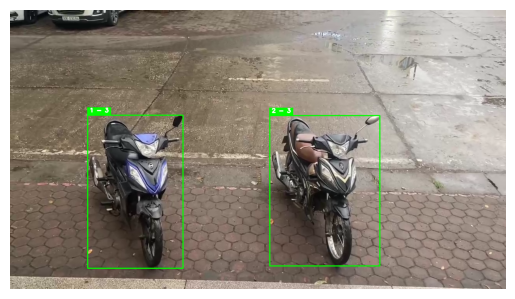


0: 384x640 1 2, 2 3s, 185.1ms
Speed: 3.1ms preprocess, 185.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


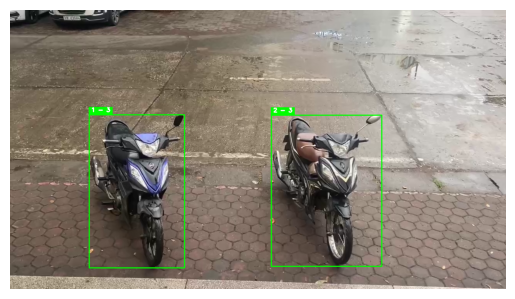


0: 384x640 2 3s, 210.2ms
Speed: 2.7ms preprocess, 210.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


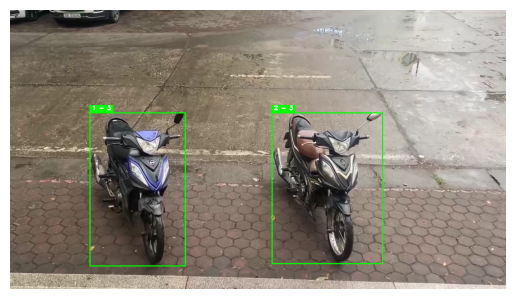


0: 384x640 2 3s, 178.7ms
Speed: 4.1ms preprocess, 178.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


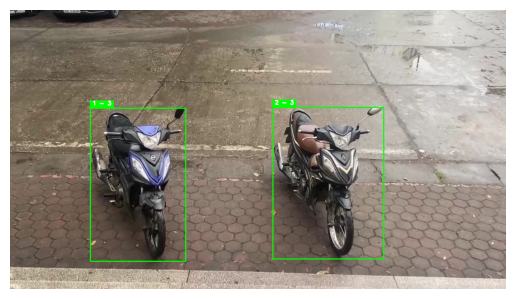


0: 384x640 2 3s, 188.2ms
Speed: 3.1ms preprocess, 188.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


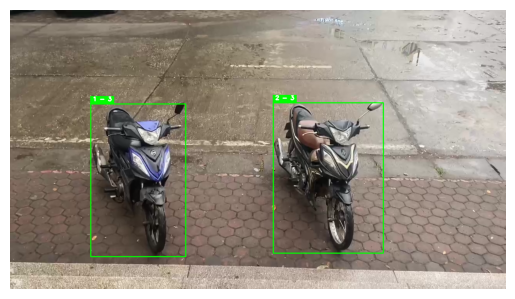


0: 384x640 2 3s, 187.2ms
Speed: 5.8ms preprocess, 187.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


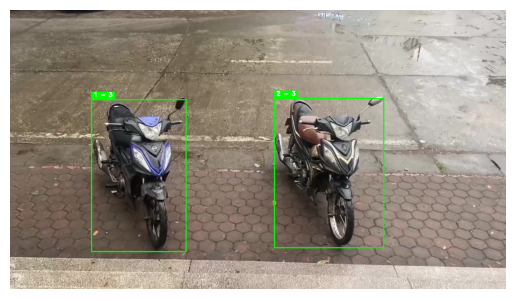


0: 384x640 2 3s, 187.5ms
Speed: 3.2ms preprocess, 187.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


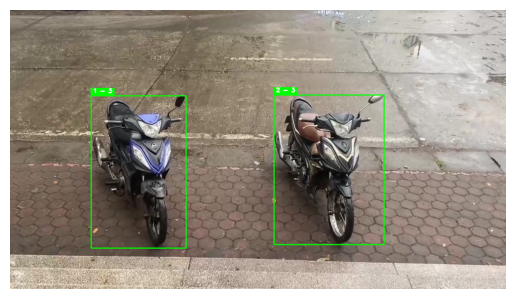


0: 384x640 2 3s, 270.9ms
Speed: 9.2ms preprocess, 270.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


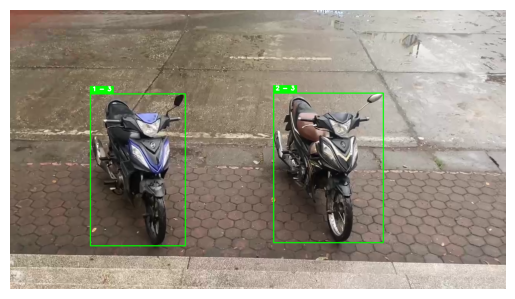


0: 384x640 2 3s, 264.7ms
Speed: 7.1ms preprocess, 264.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


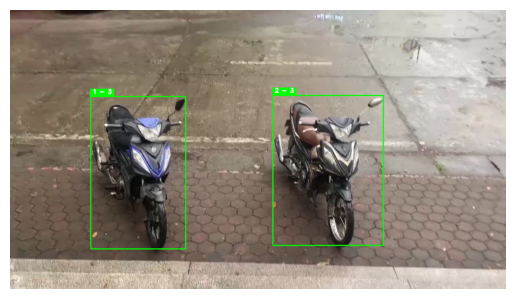


0: 384x640 2 3s, 266.1ms
Speed: 5.9ms preprocess, 266.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


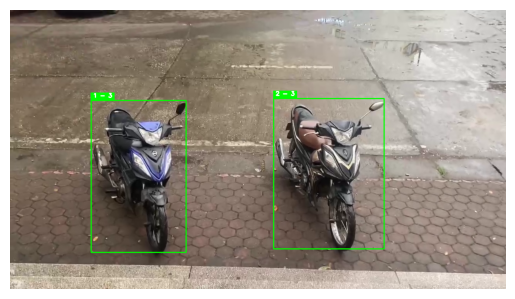


0: 384x640 2 3s, 283.3ms
Speed: 2.7ms preprocess, 283.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


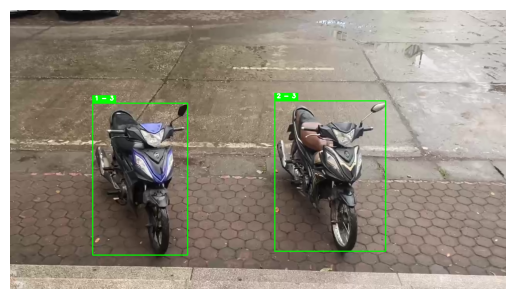


0: 384x640 2 3s, 274.4ms
Speed: 5.8ms preprocess, 274.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


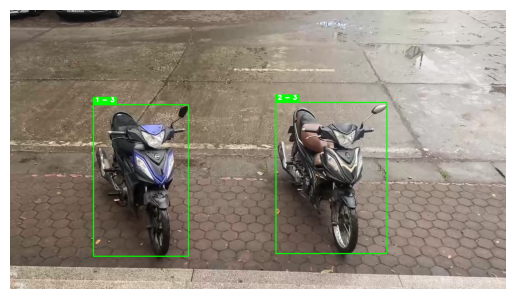


0: 384x640 2 3s, 287.3ms
Speed: 5.9ms preprocess, 287.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


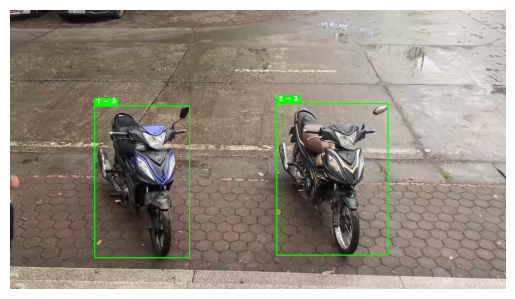


0: 384x640 1 0, 2 3s, 305.7ms
Speed: 2.6ms preprocess, 305.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


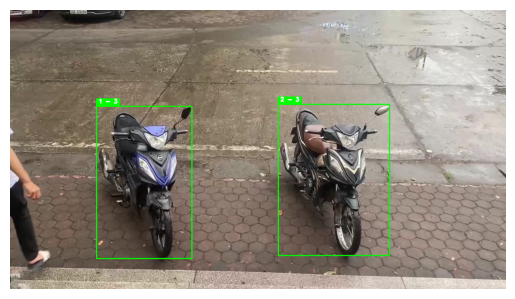


0: 384x640 1 0, 2 3s, 195.9ms
Speed: 2.7ms preprocess, 195.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


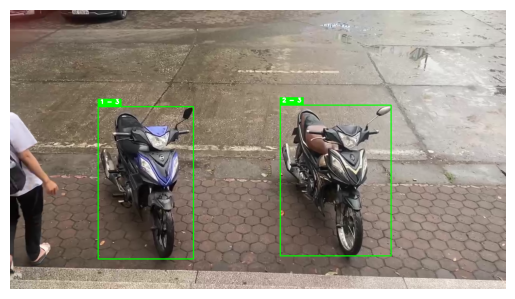


0: 384x640 1 0, 2 3s, 197.7ms
Speed: 2.7ms preprocess, 197.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


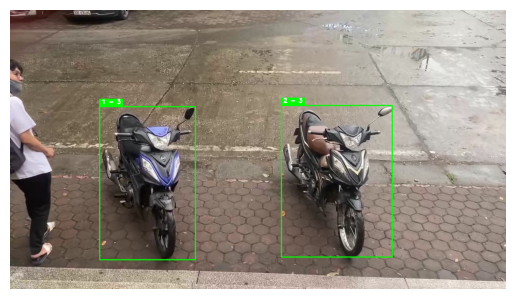


0: 384x640 1 0, 2 3s, 220.5ms
Speed: 2.9ms preprocess, 220.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


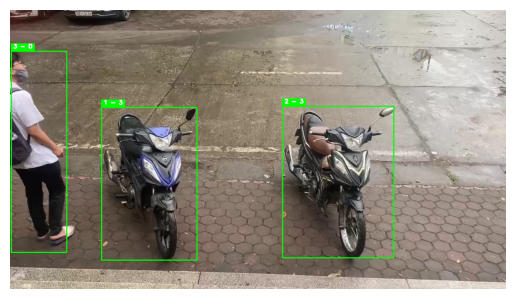


0: 384x640 1 0, 2 3s, 1 24, 1 26, 230.7ms
Speed: 8.3ms preprocess, 230.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


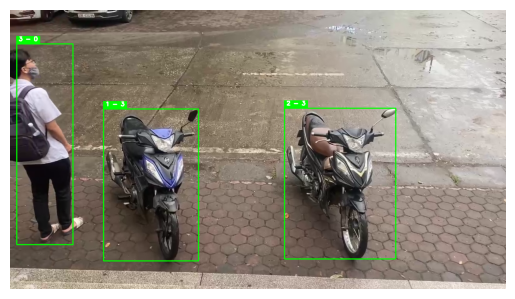


0: 384x640 1 0, 1 2, 2 3s, 204.0ms
Speed: 4.0ms preprocess, 204.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


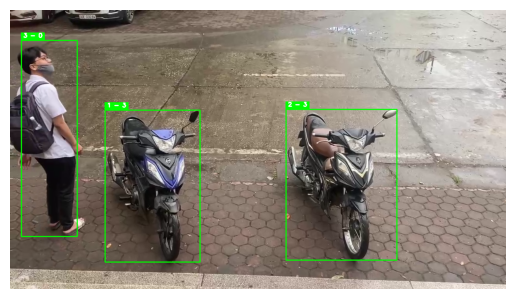


0: 384x640 1 0, 1 2, 2 3s, 1 24, 212.7ms
Speed: 2.7ms preprocess, 212.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


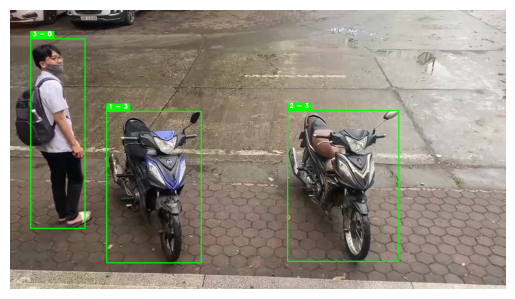


0: 384x640 1 0, 1 2, 2 3s, 1 24, 195.3ms
Speed: 5.7ms preprocess, 195.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


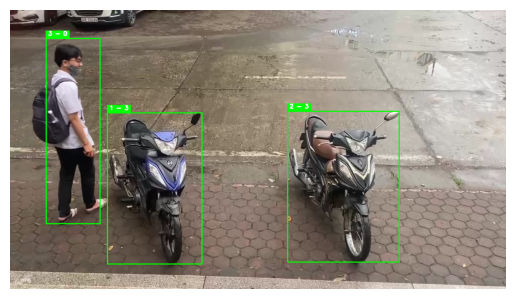


0: 384x640 1 0, 1 2, 2 3s, 1 24, 249.3ms
Speed: 4.3ms preprocess, 249.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


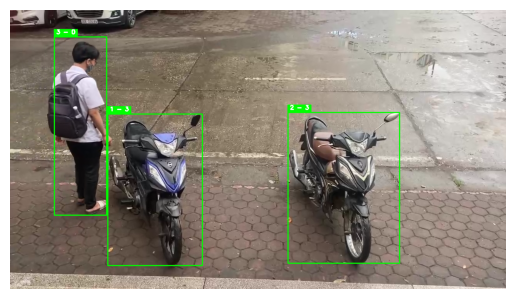


0: 384x640 1 0, 1 2, 2 3s, 1 24, 206.6ms
Speed: 9.8ms preprocess, 206.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


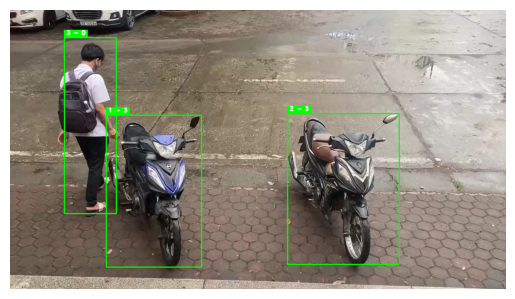


0: 384x640 1 0, 2 2s, 2 3s, 1 24, 290.5ms
Speed: 5.7ms preprocess, 290.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


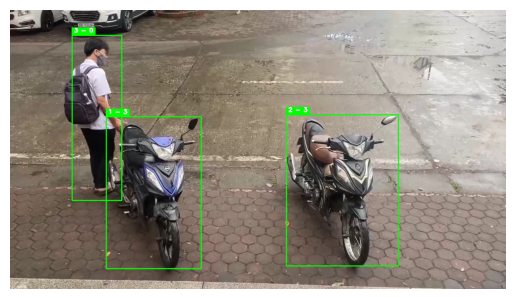


0: 384x640 1 0, 2 2s, 2 3s, 1 24, 320.3ms
Speed: 2.5ms preprocess, 320.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


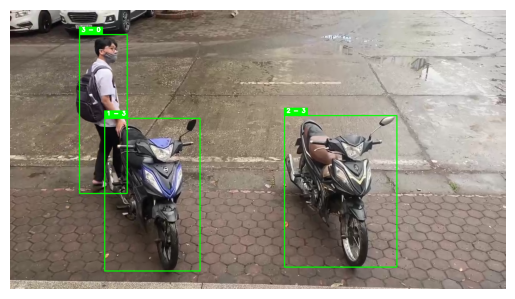


0: 384x640 2 0s, 2 2s, 2 3s, 1 24, 254.0ms
Speed: 2.6ms preprocess, 254.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


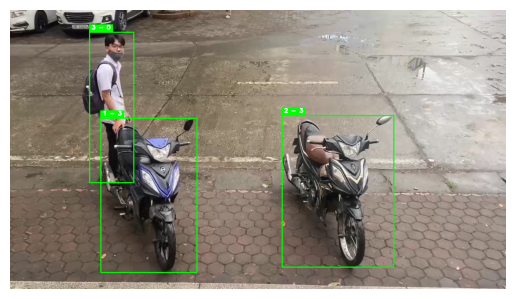


0: 384x640 1 0, 2 2s, 2 3s, 1 24, 299.5ms
Speed: 2.6ms preprocess, 299.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


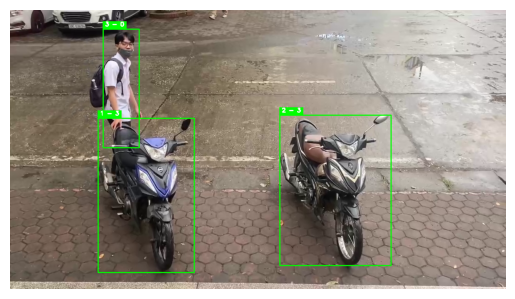


0: 384x640 1 0, 2 2s, 2 3s, 1 24, 308.1ms
Speed: 2.7ms preprocess, 308.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
+ random erase
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


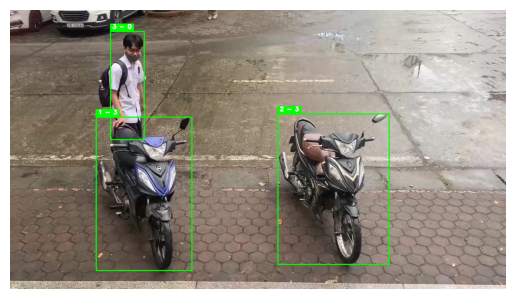

In [ ]:
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
writer = cv2.VideoWriter("/content/video.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (frame_width, frame_height))

tracker = DeepSort(max_age=10)
motorbike_owners = {}  # Mapping of motorbike ID to owner features
track_class_mapping = {}
class_counters = defaultdict(int)

i = 0
while True:
    i+=1
    ret, frame = cap.read()
    # print(i)
    if not ret: break
    if i%10==0: process_frame(frame, tracker, motorbike_owners, track_class_mapping, class_counters)
    if cv2.waitKey(1) == ord("q"): break

cap.release()
writer.release()
cv2.destroyAllWindows()